In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, GlobalMaxPooling2D, Flatten,MaxPooling2D
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam,SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from keras.regularizers import l1,l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
import tensorflow as tf
import os
import random as rn
import numpy as np
import logging
import time
from util_functions import *
from sklearn.decomposition import PCA
import h5py
import os

# Disable GPUs for test reproducibility
tf.config.set_visible_devices([], 'GPU')

print(os.listdir('./Dataset/'))

SEED=0

# DATASET_FOLDER = "./Dataset"
# RESHAPED_FOLDER = "./Reshaped_Dataset"

# DATASET_FOLDER = "./Benign-Syn"
# RESHAPED_FOLDER = "./Benign-Syn-pca"

DATASET_FOLDER = "./Traffic_Manipulator_test/Manipulated_Dataset"
RESHAPED_FOLDER = "./Traffic_Manipulator_test/Reduced_Manipulated_Dataset"

X_train, y_train = load_dataset(DATASET_FOLDER + "/*" + '-train.hdf5',channels=True)
X_val, y_val = load_dataset(DATASET_FOLDER + "/*" + '-val.hdf5',channels=True)
X_test, y_test = load_dataset(DATASET_FOLDER + "/*" + '-test.hdf5',channels=True)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

['10t-10n-DOS2019-dataset-test.hdf5', '10t-10n-DOS2019-dataset-train.hdf5', '10t-10n-DOS2019-dataset-val.hdf5']
(253, 10, 11, 1) (253,)
(29, 10, 11, 1) (29,)
(40, 10, 11, 1) (40,)


2024-12-17 13:23:18.865697: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-17 13:23:18.961440: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2024-12-17 13:23:18.961509: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [2]:
# Flatten the second and third dimensions of set_x
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1]*X_val.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(253, 110) (253,)
(29, 110) (29,)
(40, 110) (40,)


In [3]:
# Standardize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Perform PCA
pca = PCA(n_components=9, svd_solver='full')
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

print(X_train_pca.shape, X_val_pca.shape, X_test_pca.shape)
print(f"Explained variance ratio: {np.sum(pca.explained_variance_ratio_):.2f}")
print(pca.explained_variance_ratio_.cumsum())

(253, 9) (29, 9) (40, 9)
Explained variance ratio: 0.76
[0.27925003 0.38093772 0.46408886 0.53649112 0.6024626  0.65719474
 0.69540891 0.73063317 0.76381846]


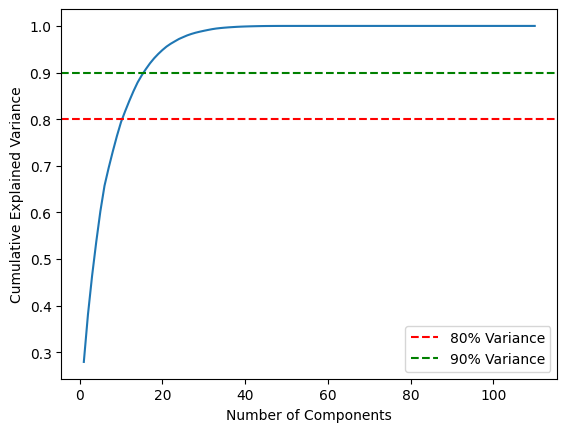

In [4]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train)

# Cumulative explained variance
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# Plot
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.8, color='r', linestyle='--', label='80% Variance')
plt.axhline(y=0.9, color='g', linestyle='--', label='90% Variance')
plt.legend()
plt.show()


In [5]:
# Reshape the dataset 
X_train_pca = X_train_pca.reshape(X_train.shape[0], 3, 3)
X_val_pca = X_val_pca.reshape(X_val.shape[0], 3, 3)
X_test_pca = X_test_pca.reshape(X_test.shape[0], 3, 3)

print(X_train_pca.shape, y_train.shape)
print(X_val_pca.shape, y_val.shape)
print(X_test_pca.shape, y_test.shape)

(253, 3, 3) (253,)
(29, 3, 3) (29,)
(40, 3, 3) (40,)


In [6]:
# Save reshaped datasets to HDF5 files
os.makedirs(RESHAPED_FOLDER, exist_ok=True)

with h5py.File(os.path.join(RESHAPED_FOLDER, 'Dataset_PCA-train.hdf5'), 'w') as f:
    f.create_dataset('set_x', data=X_train_pca)
    f.create_dataset('set_y', data=y_train)

with h5py.File(os.path.join(RESHAPED_FOLDER, 'Dataset_PCA-val.hdf5'), 'w') as f:
    f.create_dataset('set_x', data=X_val_pca)
    f.create_dataset('set_y', data=y_val)

with h5py.File(os.path.join(RESHAPED_FOLDER, 'Dataset_PCA-test.hdf5'), 'w') as f:
    f.create_dataset('set_x', data=X_test_pca)
    f.create_dataset('set_y', data=y_test)

print("Datasets saved successfully.")

Datasets saved successfully.
